C:\Users\carlo\AppData\Local\Temp\ipykernel_38092\3261130945.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outgoing_transactions[column].fillna(median_value, inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_38092\3261130945.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgoing_transactions[column].fillna(median_value, i

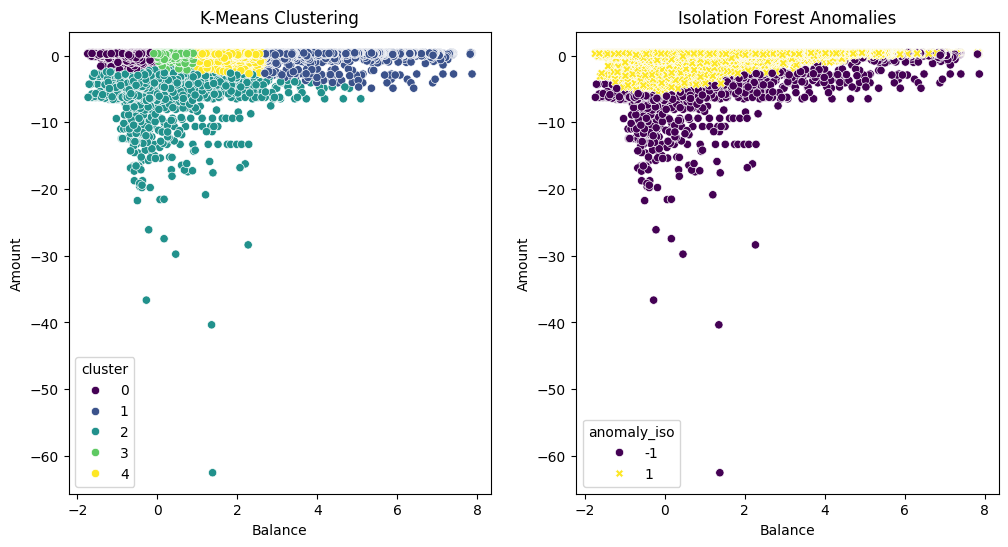

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('simulated_transaction_2024.csv')

# Convert date and timestamp into datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%H:%M').dt.time

# Cleaning up Account No by removing the '.0'
df['Account No'] = df['Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)

# Filter out only outgoing transactions
outgoing_transactions = df[df['Amount'] < 0]

# Fill NaN values in numerical columns with the median of those columns
for column in ['Balance', 'Amount']:
    median_value = outgoing_transactions[column].median()
    outgoing_transactions[column].fillna(median_value, inplace=True)

# Normalize the Balance and Amount
scaler = StandardScaler()
outgoing_transactions[['Balance', 'Amount']] = scaler.fit_transform(outgoing_transactions[['Balance', 'Amount']])

# K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
outgoing_transactions['cluster'] = kmeans.fit_predict(outgoing_transactions[['Balance', 'Amount']])

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outgoing_transactions['anomaly_iso'] = iso_forest.fit_predict(outgoing_transactions[['Balance', 'Amount']])

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Balance', y='Amount', hue='cluster', data=outgoing_transactions, palette='viridis')
plt.title('K-Means Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Balance', y='Amount', data=outgoing_transactions, hue='anomaly_iso', style='anomaly_iso', palette='viridis')
plt.title('Isolation Forest Anomalies')
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_38092\3972336754.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outgoing_transactions[column].fillna(median_value, inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_38092\3972336754.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgoing_transactions[column].fillna(median_value, i

Number of anomalies detected by K-Means: 10998
Number of anomalies detected by Isolation Forest: 2198


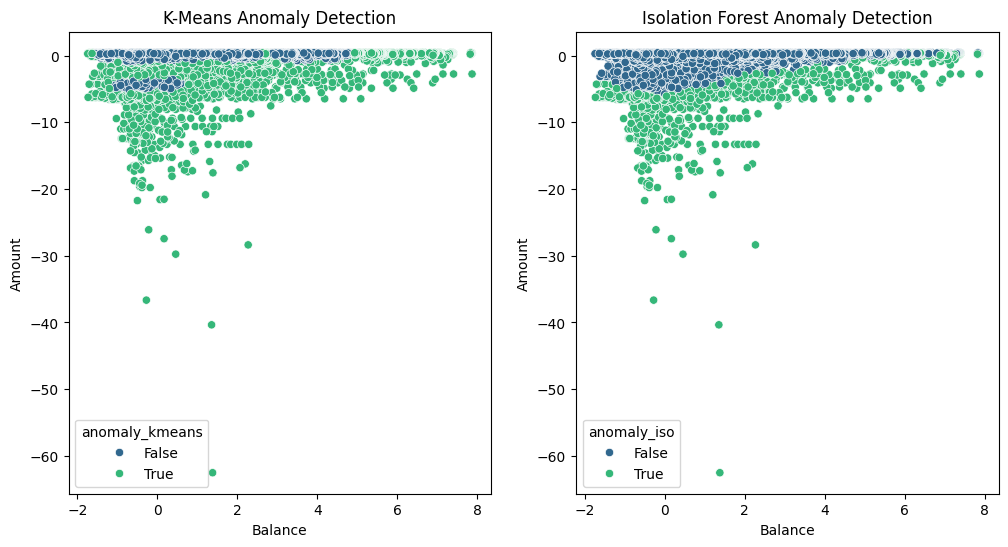

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Load the dataset
df = pd.read_csv('simulated_transaction_2024.csv')

# Convert date and timestamp into datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%H:%M').dt.time

# Cleaning up Account No by removing the '.0'
df['Account No'] = df['Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)

# Filter out only outgoing transactions
outgoing_transactions = df[df['Amount'] < 0]

# Fill NaN values in numerical columns with the median of those columns
for column in ['Balance', 'Amount']:
    median_value = outgoing_transactions[column].median()
    outgoing_transactions[column].fillna(median_value, inplace=True)

# Normalize the Balance and Amount
scaler = StandardScaler()
outgoing_transactions[['Balance', 'Amount']] = scaler.fit_transform(outgoing_transactions[['Balance', 'Amount']])

# K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
outgoing_transactions['cluster'] = kmeans.fit_predict(outgoing_transactions[['Balance', 'Amount']])
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster centroid
distances = cdist(outgoing_transactions[['Balance', 'Amount']], centroids, 'euclidean')
min_distances = np.min(distances, axis=1)
distance_threshold = np.percentile(min_distances, 95)  # Set threshold as 95th percentile of distances
outgoing_transactions['anomaly_kmeans'] = min_distances > distance_threshold  # Anomaly if beyond the threshold

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outgoing_transactions['anomaly_iso'] = iso_forest.fit_predict(outgoing_transactions[['Balance', 'Amount']])
outgoing_transactions['anomaly_iso'] = outgoing_transactions['anomaly_iso'] == -1  # Convert to boolean

# Count anomalies
anomalies_kmeans = outgoing_transactions['anomaly_kmeans'].sum()
anomalies_iso = outgoing_transactions['anomaly_iso'].sum()

print(f"Number of anomalies detected by K-Means: {anomalies_kmeans}")
print(f"Number of anomalies detected by Isolation Forest: {anomalies_iso}")

# Visualization for comparison (optional)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Balance', y='Amount', hue='anomaly_kmeans', data=outgoing_transactions, palette='viridis')
plt.title('K-Means Anomaly Detection')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Balance', y='Amount', hue='anomaly_iso', data=outgoing_transactions, palette='viridis')
plt.title('Isolation Forest Anomaly Detection')
plt.show()
